# Самостоятельная работа № 1

### Задание 1

Модуль лингвистической предобработки текста является одним из важнейших компонентов современных TTS систем.
Стандартный набор преобразований над текстом включает в себя:
- нормализацию 
- токенизацию 
- построение транскрипции

Нормализация подразумевает расшифровку числовых последовательностей, дат, оббревиатур, иноязычных вставок, сокращений и т.д. (не путать с приведением к нормальной форме слов - принятой терминологиией в NLP).

Токенизация - разбиение текста на предложения и слова.

Построение транскрипции позволяет получить из графемного фонемное представление текста. На этом же этапе разрешается пробелма расстановки ударений. 

Предлагается построить простой пайплайн лингвистической предобработки: токенизация на предложения, нормализация каждого предложения, получение фонемной последовательности для каждого предложения.

In [1]:
import os
import sys
import uuid
import warnings

import torch
import librosa
import librosa.display
import numpy as np
from razdel import sentenize
from russian_g2p.Accentor import Accentor

from matplotlib import pyplot as plt
import IPython.display as ipd
%matplotlib inline

from utils import Normalizer

In [2]:
# ваш номер
my_id = uuid.uuid4().hex
print(my_id)

a9d9eb03c1084a0c8d4a1b903b860ff6


In [3]:
# Исходный текст
input_text = "В 1785 г в городе Augsburg случилось странное проишествие. Группа в 18 человек, где каждый весил не менее 100 кг, устроила праздник на втором этаже деревянного здания."

In [4]:
def tokenize_by_sent(text):
    return [_.text for _ in (sentenize(text))]

In [5]:
sentences = tokenize_by_sent(input_text)

In [6]:
print(sentences)

['В 1785 г в городе Augsburg случилось странное проишествие.', 'Группа в 18 человек, где каждый весил не менее 100 кг, устроила праздник на втором этаже деревянного здания.']


Токенизация на предложения нужна и при подготовке обучающих баз и при инференсе системы. Обучать модель на длинных текстах как правило не целесообразно. 

Токенизация на слова может понадобится для получения границ слов, получения знаков препринания, может требоваться для более качественной нормализации.

In [7]:
def normalize(text):
    return Normalizer().norm_text(text)

In [8]:
norm_sentences = [normalize(sentence) for sentence in sentences]

100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


In [9]:
print(norm_sentences)

['В тысяча семьсот восемьдесят пятый год в городе огсбург случилось странное проишествие.', 'Группа в восемнадцать человек, где каждый весил не менее ста килограммов, устроила праздник на втором этаже деревянного здания.']


Нормализация текста - сложная задача. Далеко не всегда открытые решения хорошо с ней справляются. Нормализация на основе лингвистических баз и правил может справляться с задачей лучше, чем нейросетевая модель.

In [10]:
def g2p(text):
    return Accentor().do_accents([[x] for x in text.split()])[0]

In [11]:
warnings.simplefilter("ignore", UserWarning)
phonemes_sequences = [g2p(sentence) for sentence in norm_sentences]

In [12]:
print(phonemes_sequences)

[['в', 'ты+сяча', 'семьсо+т', 'во+семьдесят', 'пя+тый', 'го+д', 'в', 'го+роде', 'огсбург', 'случи+лось', 'стра+нное', 'проишествие.'], ['гру+ппа', 'в', 'восемна+дцать', 'человек,', 'где+', 'ка+ждый', 'ве+сил', 'не', 'ме+нее', 'ста+', 'килограммов,', 'устро+ила', 'пра+здник', 'на', 'второ+м', 'этаже+', 'деревя+нного', 'здания.']]


In [13]:
with open(f"resources/result-lab-03-01/result_1_{my_id}.txt", 'w') as f_out:
    for sequence in phonemes_sequences:
        f_out.write(f'{" ".join(sequence)}\n')

Насколько можно видеть, итоговая последовательность может представлять из себя простой список из фонем, к котором не видно границ слов или знаков препинания.
В самом просто варианте, границы слов можно обозначить пробельным символом. Однако знаки препинания лучше исключить из финальной последовательности, т.к. их наличие будет мешать модели выстраивать матрицу внимания (какой длительности будет многоточие или знак вопроса?). 

### Задание 2

Пайплайн получения признаков из аудио для TTS может быть достаточно сложным.
Последовательность обработчиков и их параметры будут зависеть в том числе и от особенностей вокодера. 
Наиболее распространенным вариантом акустических признаков является логарифмированная мел-спектрограмма.

Задание - реализовать функции построения мел-спектрограммы с заданными параметрами.

Общий вид пайплайна такой: Входной сигнал -> Pre-emphasis -> STFT -> Магнитуда-> Мел-скейл -> Логарифмирование

In [14]:
def read_wave(wave_path):
    return librosa.load(wave_path)

wave_path = "resources/example.wav"
wave, sr = read_wave(wave_path)

In [15]:
print(f"Sample rate = {sr}")
print(f"Wave max = {np.max(wave)} Wave min {np.min(wave)}")

Sample rate = 22050
Wave max = 0.4473876953125 Wave min -0.579498291015625


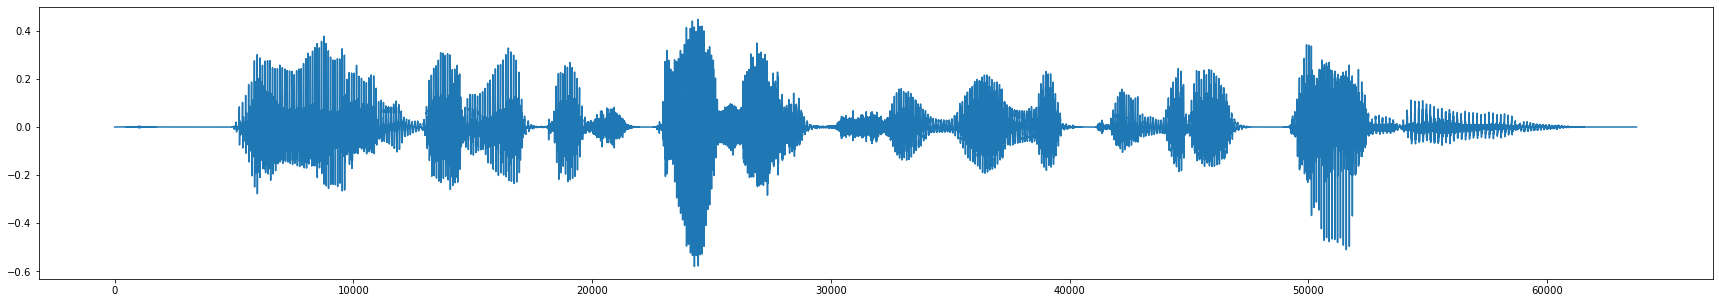

In [16]:
plt.figure(figsize=(30, 5))
plt.plot(wave);

In [17]:
ipd.Audio(wave, rate=sr)

Данные могут быть в формате float32 или int16 (обычно ...). Нужно привести к формату float32 в диапазоне значений [0, 1]. Стоит обратить внимание на максимальное и минимальное значение (если значения близки к максимум и минимуму диапазона, возможно они были нормализованы или даже клипированы). 

In [18]:
def preemphasis(x, coef=0.97):
    return np.append(x[0], x[1:] - coef * x[:-1])

preemh_wave = preemphasis(wave, 0.97)

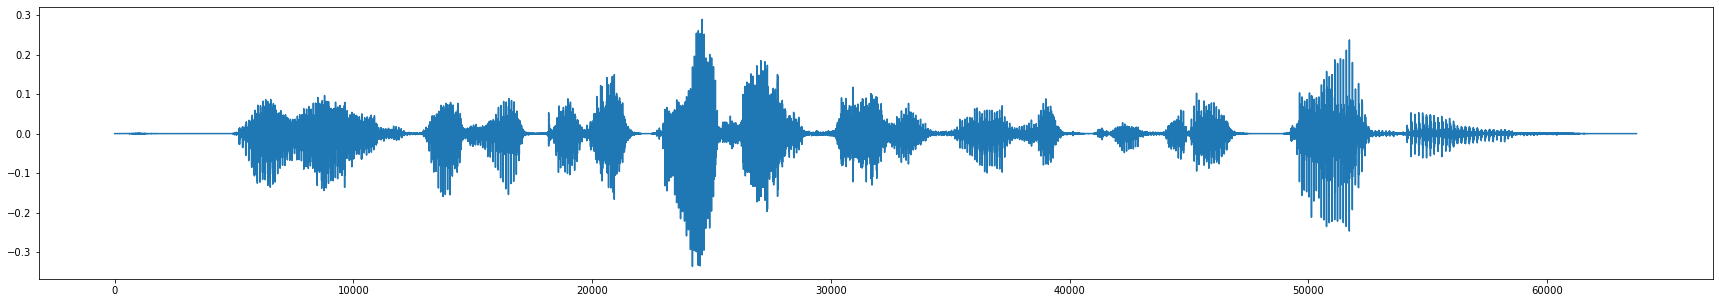

In [19]:
plt.figure(figsize=(30, 5))
plt.plot(preemh_wave);

Обратимое преобразование. Усиливает высокие частоты, ослабляет низкие. 

В вокодерах необходим для уменьшения высокочастотного шума при мю-кодировании.


In [20]:
def get_stft(data, n_fft, hop, window):
    return librosa.stft(data, n_fft=n_fft, hop_length=hop, win_length=n_fft, window=window, center=False)

stft_features = get_stft(preemh_wave, 1024, 256, 'hann')

Short-time Fourier transform. Комплексные значения признаков. 

Окно анализа обычно соразмерно средней длине фонемы, шаг близким к средней длине коротких фонем (эвристические соображения от которых стоит отталкиваться).

In [21]:
def get_magnitude(features):
    return np.abs(features) ** 2

magnitude_features = get_magnitude(stft_features)

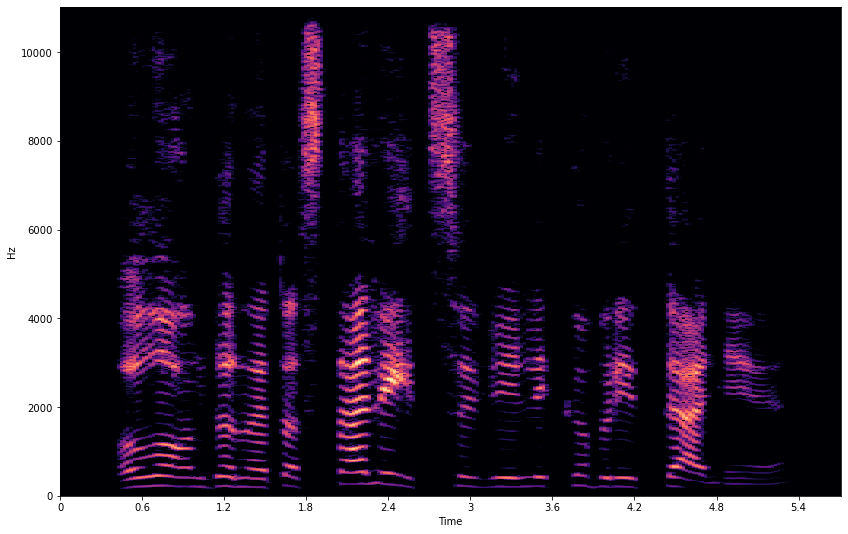

In [22]:
plt.figure(figsize=(14, 9))
D = librosa.amplitude_to_db(magnitude_features, ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr)

Теряется информация о фазе (фазовые признаки значительно менее структурированы). Признаки все еще довольно большого размера. В некоторых моделях TTS применяются и такие.

In [23]:
def get_mel_features(magnitude_features, mel_basis):
    return np.dot(magnitude_features, mel_basis)

def get_mel_basis(sample_rate, n_fft, size):
    return librosa.filters.mel(sample_rate, 1024, n_mels=size)

mel_basis = get_mel_basis(sr, 1024, 100)
mel_features = get_mel_features(mel_basis, magnitude_features)

In [24]:
print(f"max {mel_features.max()} min {mel_features.min()} mean {mel_features.mean()}")

max 3.5033822059631348 min 0.0 mean 0.013599149882793427


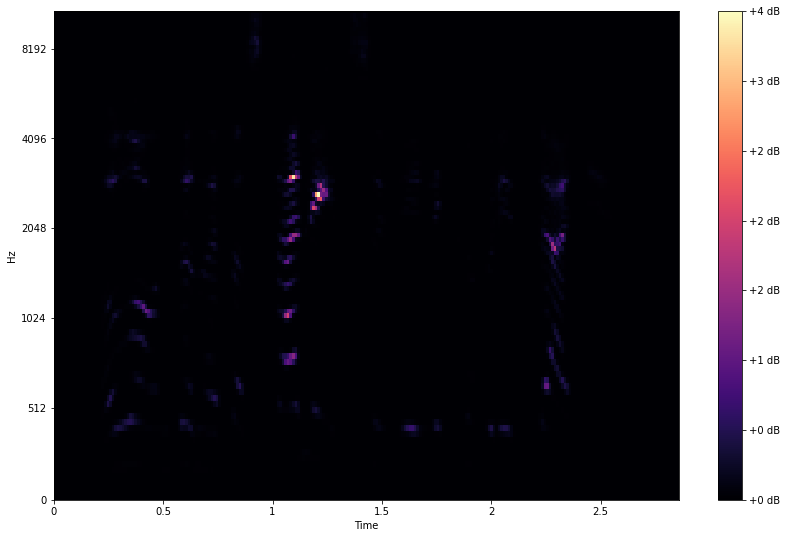

In [25]:
plt.figure(figsize=(14, 9))
librosa.display.specshow(mel_features, sr=sr, hop_length=256, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

Значительно уменьшается размер признаков, при этом практически не теряется воспринимаемое акустическое качество.

In [26]:
def get_log_features(features):
    return librosa.power_to_db(features)

log_mel_features = get_log_features(mel_features)

In [27]:
print(f"max {log_mel_features.max()} min {log_mel_features.min()} mean {log_mel_features.mean()}")

max 5.444875240325928 min -74.55512237548828 mean -43.2470817565918


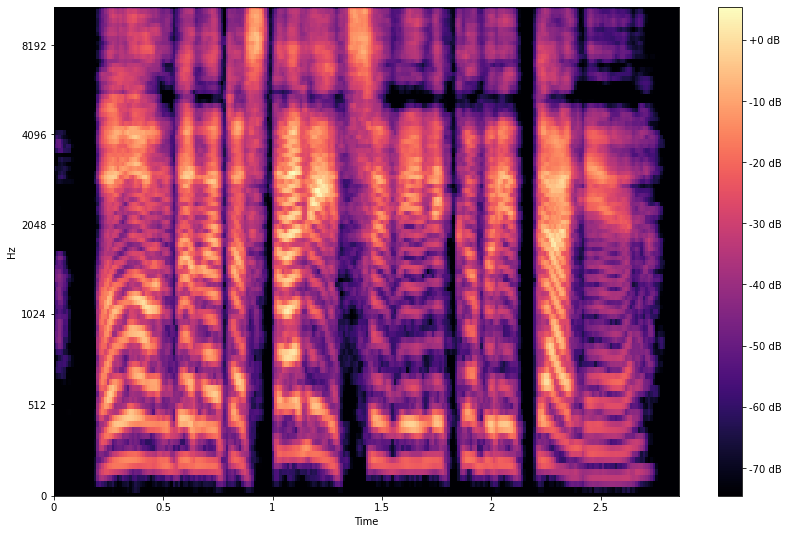

In [28]:
plt.figure(figsize=(14, 9))
librosa.display.specshow(log_mel_features, sr=sr, hop_length=256, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

Такие признаки уже можно нормализовать.

Совет - посмотрите, как будет выглядеть эти же признаки без pre-emphasis.

In [29]:
np.save(f"resources/result-lab-03-01/log_mel_features_{my_id}.npy", log_mel_features)

### Задание 3

Механизм внимания позволяет модели отображать последовательность фонем на спектрограмму. Базовый вариант, предложенный в модели Tacotron 1, называется content based attention.

Этот простой механизм пришел в TTS из области машинного перевода и он не учитывает многих особенностей синтеза речи. В главном это монотонный и локальный характер внимания. 

Монотонность обеспечивается тем, что порядок звуков и фонем одинаковый (если одна фонема находится в порядке после другой, то и ее признаки в спектрограмме будут находится после признаков первой, в отличие от задачи машинного перевода, где порядок слов в разных языках может отличаться). 

Локальность обеспечивается тем, что фонемы влияют на звучание только своих ближайших соседей.

Не очень подходящий механзм внимания значительно влияет на качество и естественность речи. Непрерывные длинные участки речи с ним вообще крайне затруднительно синтезировать (внимание "ломается", "рассыпается", пропадают звуки, слова, речь заедает, звучит "белиберда", ломается голос, интонации).

Разработано уже много вариантов улучшения механизма внимания. А одни из лучших способов - сразу прогнозировать длительность фонем.

Попробуем на игрушечном примере построить один из рабочих вариантов механизма внимания FORWARD ATTENTION (https://arxiv.org/pdf/1807.06736.pdf). 

In [30]:
import torch
import numpy as np

In [31]:
seq_len = 100
enc_size = 32
attn_rnn_size = 16
dec_rnn_size = 16
attn_inner_size = 32
decoder_steps = 200 # у нас нет остановки, поэтому зададим заранее количество шагов декодера

In [32]:
encoder_output = torch.from_numpy(np.load("resources/encoder_output.npy"))

In [33]:
class Attention(torch.nn.Module):
    def __init__(self, query_size, key_size, attn_inner_size):
        super(Attention, self).__init__()
        self.softmax = torch.nn.Softmax(dim=0)
        self.query = torch.nn.Linear(query_size, attn_inner_size, bias=False)
        self.key = torch.nn.Linear(key_size, attn_inner_size, bias=False)
        self.v = torch.nn.Linear(attn_inner_size, 1, bias=False)

    def forward(self, queries, keys):
        keys = self.key(keys)
        queries = self.query(queries)
        attn = self.v(torch.tanh((queries + keys)).squeeze())
        attn = self.softmax(attn)
        return attn


class SimpleAttnDecoder(torch.nn.Module):
    def __init__(self, enc_size, attn_rnn_size, dec_rnn_size, attn_inner_size):
        super(SimpleAttnDecoder, self).__init__()
        self.attn_rnn_size = attn_rnn_size
        self.dec_rnn_size = dec_rnn_size
        self.enc_size = enc_size
        self.attention = Attention(attn_rnn_size, enc_size, attn_inner_size)
        self.rnn_attn = torch.nn.RNNCell(input_size=enc_size, hidden_size=attn_rnn_size)
        self.rnn_decoder = torch.nn.RNNCell(input_size=enc_size, hidden_size=dec_rnn_size)

    def forward(self, encoder_output, output_len):
        attention_matrix = []
        outputs = []
        attention_state = torch.zeros(1, self.attn_rnn_size).float()
        decoder_state = torch.zeros(1, self.dec_rnn_size).float()
        context = torch.zeros(1, self.enc_size).float()

        a = torch.zeros(self.attention(attention_state , encoder_output).shape[0]).float()
        a[0] = 1
        
        for idx in range(1, output_len):
            attention_state = self.rnn_attn(context, attention_state)
            attention_probs = self.attention(attention_state , encoder_output)
            
            a_prev = a.roll(1)
            a_prev[0] = 0

            a = (a + a_prev) * attention_probs.transpose(0,1).squeeze(0)
            a = a / (torch.sum(a))
            attention_probs = a.unsqueeze(0).transpose(0,1)
            
            context = torch.mm(encoder_output.squeeze().transpose(0,1), attention_probs).transpose(0,1)
            decoder_state = self.rnn_decoder(context, decoder_state)

            attention_matrix.append(attention_probs)
            outputs.append(decoder_state)
    
        attention_matrix = torch.stack(attention_matrix).transpose(0,1).squeeze()
        outputs = torch.stack(outputs).transpose(0,1).squeeze()
        return outputs, attention_matrix

In [34]:
decoder = SimpleAttnDecoder(enc_size, attn_rnn_size, dec_rnn_size, attn_inner_size)
decoder.load_state_dict(torch.load("resources/decoder_state_dict.pt"))

<All keys matched successfully>

In [35]:
with torch.no_grad():
    outputs, attention_matrix = decoder(encoder_output, decoder_steps)

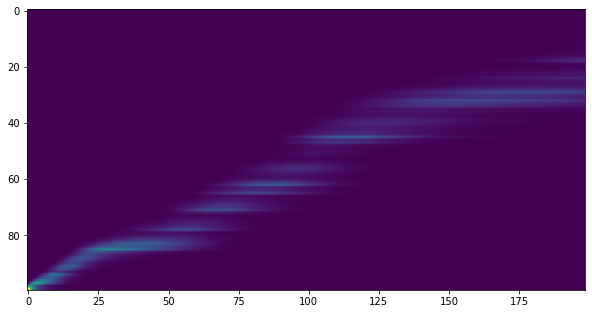

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(attention_matrix.flip(0));

In [37]:
np.save(f"resources/result-lab-03-01/attention_{my_id}.npy", attention_matrix.flip(0).numpy())

Матрица внимания будет значительно диагональнее (и это модель со случайным входом и случайными весами!)